In [1]:
import sys
print(sys.version)

3.11.1 (tags/v3.11.1:a7a450f, Dec  6 2022, 19:58:39) [MSC v.1934 64 bit (AMD64)]


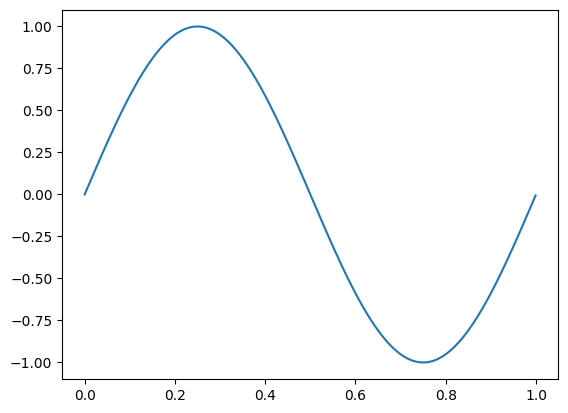

In [3]:
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import sine_data
import numpy as np
#import cupy as np
import time

nnfs.init()

X, y = sine_data()

plt.plot(X, y)
plt.show()

### Dense Layer

In [4]:
class Layer_Dense:

    # Layer initialization
    def __init__(self, n_inputs, n_neurons,
                weight_regularizer_l1=0., weight_regularizer_l2=0., 
                bias_regularizer_l1=0., bias_regularizer_l2=0.):

        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases  = np.zeros((1, n_neurons))
        self.dinputs = 0
        
        # Set regularization strength
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1   = bias_regularizer_l1
        self.bias_regularizer_l2   = bias_regularizer_l2

    # Forward pass
    def forward(self, inputs):
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradient on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases  = np.sum(dvalues, axis=0, keepdims=True)
        
        # Gradient on regularization
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1

        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
        
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1

        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases
        
        # Gradient on values
        self.dinputs  = np.dot(dvalues, self.weights.T)

### ReLU activation

In [5]:
class Activation_ReLU:

    # Forward pass
    def forward(self, inputs):
        self.inputs = inputs

        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)
        self.dinputs = 0

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify the original variable, 
        # let's make a copy of the variable first 
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

### Optimizer Adam - [Adaptive Momentum]

In [6]:
class Optimizer_Adam:

    # Initialize optimizer
    def __init__(self, learning_rate=0.001, decay=0.0, epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate          = learning_rate
        self.current_learning_rate  = learning_rate
        self.decay                  = decay
        self.iterations             = 0
        self.epsilon                = epsilon
        self.beta_1                 = beta_1
        self.beta_2                 = beta_2

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = \
                self.learning_rate * (1.0 / (1.0+self.decay * self.iterations))
    
    # Update parameters
    def update_params(self, layer):

        # Create cache arrays if not exist
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache     = np.zeros_like(layer.weights)
            layer.bias_momentums   = np.zeros_like(layer.biases)
            layer.bias_cache       = np.zeros_like(layer.biases)

        # Update momentum with current gradients
        layer.weight_momentums = \
            self.beta_1 * layer.weight_momentums + (1-self.beta_1)*layer.dweights
        layer.bias_momentums = \
            self.beta_1 * layer.bias_momentums   + (1-self.beta_1)*layer.dbiases

        # Get corrected momentum
        # self.iteration is 0 at first pass
        # and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations+1))
        bias_momentums_corrected   = layer.bias_momentums   / (1 - self.beta_1 ** (self.iterations+1))

        # Update cache with squared current gradients
        layer.weight_cache = \
            self.beta_2 * layer.weight_cache + (1-self.beta_2)*layer.dweights**2
        layer.bias_cache = \
            self.beta_2 * layer.bias_cache   + (1-self.beta_2)*layer.dbiases**2

        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / (1-self.beta_2**(self.iterations+1))
        bias_cache_corrected   = layer.bias_cache   / (1-self.beta_2**(self.iterations+1))

        # Vanilla SGD parameter update + normalization with sqrt cache
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases  += -self.current_learning_rate * bias_momentums_corrected   / (np.sqrt(bias_cache_corrected)   + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

### Linear Activation

In [7]:
# Linear Activation
class Activation_Linear:

    # Forward pass
    def forward(self, inputs): 
        self.inputs = inputs
        self.output = inputs

    # Backward pass
    def backward(self, dvalues):
        # Derivative is 1, 1*dvalues = dvalues - the chain rule
        self.dinputs = dvalues.copy()

### Common Loss class

In [8]:
class Loss:

    # Regularization loss calculation
    def regularization_loss(self, layer):
        
        regularization_loss = 0        
        
        # L1/L2 regularization (if factor greater than 0)
        
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
        
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)
        
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
        
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)

        return regularization_loss
        
    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        return np.mean(sample_losses)

    def forward(self, y_pred, y_true):
        return []

### Mean Squared Error loss

In [9]:
class Loss_MeanSquaredError(Loss):   # L2 Loss
    
    # Forward pass
    def forward(self, y_pred, y_true): 
        # Calculate loss
        sample_losses = np.mean((y_true - y_pred)**2, axis=-1)
        return sample_losses
 
    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        outputs = len(dvalues[0])
        
        # Gradient on values
        self.dinputs = -2 * (y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples

### Mean Absolute Error Loss

In [10]:
class Loss_MeanAbsoluteError(Loss):   # L1 loss

    # Forward pass
    def forward(self, y_pred, y_true):

        # Calculate loss
        sample_losses = np.mean(np.abs(y_true - y_pred), axis=-1)
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):

        samples = len(dvalues)
        outputs = len(dvalues[0])

        # Calculate gradient
        self.dinputs = np.sign(y_true - dvalues) / outputs

        # Normalize gradient
        self.dinputs = self.dinputs / samples
        

### Create my very own copy of torch.nn.Module

In [11]:
class Module:
    def __init_(self):
        self.layer_stack = [['mats', 123]]
        self.inputs  = 0
        self.neurons = 0
        self.outputs = 0
        
    def forward(self, inputs):
        xx = inputs
        for [name, model] in self.layer_stack:
            model.forward(xx)
            xx = model.output
        self.output = xx

    def backward(self, dvalues):
        xx = dvalues
        for [name, model] in self.layer_stack[::-1]:
            model.backward(xx)
            xx = model.dinputs
        self.dinputs = xx

    def __getitem__(self, argx):
        if type(argx) == int: 
            return self.layer_stack[argx][1]
        elif type(argx) == str:
            [p] = [i[1] for i in self.layer_stack if argx in i]
            return p
        else:
            print("We have found an error. Sit back and relax. Help is on the way")

    def __repr__(self):
        s = ""
        s += f'inputs  = {self.inputs:4d}\n'
        s += f'neurons = {self.neurons:4d}\n'
        s += f'outputs = {self.outputs:4d}\n'
        for [name, mode] in self.layer_stack:
            s += f'Name: {name:<10}: model: {mode}\n'
        return s

    def __str__(self):
        s = ""
        s += f'inputs  = {self.inputs:4d}\n'
        s += f'neurons = {self.neurons:4d}\n'
        s += f'outputs = {self.outputs:4d}\n'
        for [name, mode] in self.layer_stack:
            s += f'Name: {name:<10}: model: {mode}\n'
        return s


### Setup the layer in Model0

In [12]:
class Model0(Module): 

    def __init__(self, inputs, neurons, outputs):
        super().__init__()

        self.inputs  = inputs
        self.neurons = neurons
        self.outputs = outputs
        self.layer_stack = [
            ['dense1', Layer_Dense(inputs, neurons)],
            ['ReLU'  , Activation_ReLU()],
            ['dense2', Layer_Dense(neurons, neurons)],
            ['linear', Activation_ReLU() ],
            ['dense3', Layer_Dense(neurons, outputs)],
            ['Linear', Activation_Linear() ]
            ]


### Create the model

In [13]:
# Create DataSet
X,y = sine_data()
# X = np.array(X)     # For CuPy
# y = np.array(y)     # For CuPy

In [14]:

# Create model
model = Model0(1,64,1)

loss_function = Loss_MeanSquaredError()
optimizer     = Optimizer_Adam(learning_rate=0.005, decay=1e-3)

accuracy_precision = np.std(y) / 250
print('accuracy_precision: ', accuracy_precision)

accuracy_precision:  0.0028284271247461905


### Train in loop

In [15]:
start_time = time.time()
for epoch in range(10001):
    # Forward
    model.forward(X)
    # loss
    data_loss = loss_function.calculate(model.output, y)

    regularization_loss = \
        loss_function.regularization_loss(model['dense1']) + \
        loss_function.regularization_loss(model['dense2']) + \
        loss_function.regularization_loss(model['dense3'])
    
    loss = data_loss + regularization_loss

    predictions = model.output
    accuracy    = np.mean(np.absolute(predictions - y) < accuracy_precision)

    if not epoch % 100: 
        print(  f'epoch: {epoch:<5d} | '   +
                f'acc : {accuracy:.3f} |' +
                f'loss : {loss:.3f} [' +
                f'data_loss : {data_loss:.3f} |' +
                f'reg_loss : {regularization_loss:.3f}] | ' +
                f'lr : {optimizer.current_learning_rate:.3f} |')

    # Backward pass
    loss_function.backward(model.output, y)
    model.backward(loss_function.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(model['dense1'])
    optimizer.update_params(model['dense2'])
    optimizer.update_params(model['dense3'])
    optimizer.post_update_params()

end_time = time.time()
print("Total time: ", end_time - start_time," seconds")

epoch: 0     | acc : 0.002 |loss : 0.500 [data_loss : 0.500 |reg_loss : 0.000] | lr : 0.005 |
epoch: 100   | acc : 0.007 |loss : 0.084 [data_loss : 0.084 |reg_loss : 0.000] | lr : 0.005 |
epoch: 200   | acc : 0.033 |loss : 0.034 [data_loss : 0.034 |reg_loss : 0.000] | lr : 0.004 |
epoch: 300   | acc : 0.020 |loss : 0.003 [data_loss : 0.003 |reg_loss : 0.000] | lr : 0.004 |
epoch: 400   | acc : 0.618 |loss : 0.000 [data_loss : 0.000 |reg_loss : 0.000] | lr : 0.004 |
epoch: 500   | acc : 0.605 |loss : 0.000 [data_loss : 0.000 |reg_loss : 0.000] | lr : 0.003 |
epoch: 600   | acc : 0.732 |loss : 0.000 [data_loss : 0.000 |reg_loss : 0.000] | lr : 0.003 |
epoch: 700   | acc : 0.763 |loss : 0.000 [data_loss : 0.000 |reg_loss : 0.000] | lr : 0.003 |
epoch: 800   | acc : 0.778 |loss : 0.000 [data_loss : 0.000 |reg_loss : 0.000] | lr : 0.003 |
epoch: 900   | acc : 0.789 |loss : 0.000 [data_loss : 0.000 |reg_loss : 0.000] | lr : 0.003 |
epoch: 1000  | acc : 0.135 |loss : 0.000 [data_loss : 0.000 

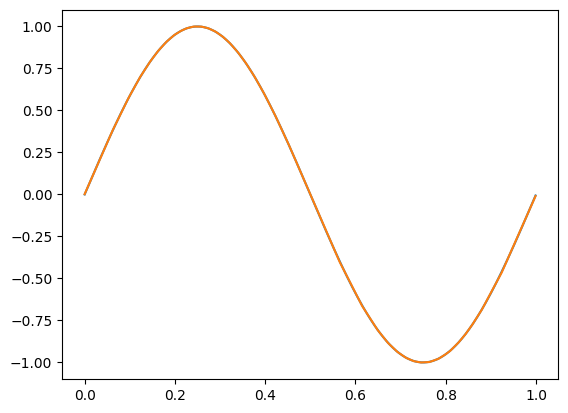

In [16]:
import matplotlib.pyplot as plt

X_test, y_test = sine_data()
# X_test = np.array(X_test)   # For CuPy
# y_test = np.array(y_test)   # For CuPy

model.forward(X_test)

# FOR CuPy ## plt.plot(np.asnumpy(X_test), np.asnumpy(y_test))
# FOR CuPy ## plt.plot(np.asnumpy(X_test), np.asnumpy(model.output))
# FOR CuPy ## plt.show()
plt.plot(X_test, y_test)
plt.plot(X_test, model.output)
plt.show()

In [ ]:
model['dense1'].weights, model['dense1'].biases


In [ ]:
weights